In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import time

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 回归问题

手动生成回归任务的数据集：

生成单个数据集。
数据集的大小为10000且训练集大小为7000，测试集大小为3000,数据集的样本特征维度p为500

In [2]:
# 设置随机数种子，确保结果可重复
np.random.seed(42)
torch.manual_seed(42)

# 定义批量大小
batch_size = 256
# 定义数据集的总大小
n_total = 10000
# 定义训练集的大小
n_train = 7000
n_test = n_total - n_train
# 定义特征的维度
p = 500

# 定义真实的权重和偏置
true_w, true_b = torch.ones((p, 1)) * 0.01, 0.05
# 生成随机特征
features = torch.randn((n_total, p))
# 计算标签，使用线性模型
labels = torch.matmul(features, true_w) + true_b
# 添加一些高斯噪声到标签中
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

train_features, test_features = features[:n_train, :], features[n_train:, :]

train_labels, test_labels = labels[:n_train], labels[n_train:]

# 打印训练集和测试集的特征形状
print(train_features.shape, test_features.shape)

torch.Size([7000, 500]) torch.Size([3000, 500])


In [3]:
def data_iter(batch_size, features, labels):
    dataset = TensorDataset(features, labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

train_loader = data_iter(batch_size, train_features, train_labels)
test_loader = data_iter(batch_size, test_features, test_labels)

# 测试
for X, y in train_loader:
    print(X.shape, y.shape)
    break
for X, y in test_loader:
    print(X.shape, y.shape)
    break

torch.Size([256, 500]) torch.Size([256, 1])
torch.Size([256, 500]) torch.Size([256, 1])


In [4]:
# 定义损失函数
def myMSELoss(y_hat, y):
    return torch.mean((y_hat - y.view(y_hat.size())) ** 2)

# 测试损失函数
y = torch.randn((3, 7))
y_hat = torch.randn((3, 7))
print(myMSELoss(y_hat, y))
print(torch.nn.MSELoss()(y_hat, y))

tensor(1.6877)
tensor(1.6877)


In [17]:
# 定义前馈神经网络
class myFFN():
    def __init__(self, num_inputs, num_outputs, num_hiddens, device='cpu'):
        self.W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float).to(device)
        self.b1 = torch.zeros(num_hiddens, dtype=torch.float).to(device)
        self.W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float).to(device)
        self.b2 = torch.zeros(num_outputs, dtype=torch.float).to(device)
        self.params = [self.W1, self.b1, self.W2, self.b2]
        for param in self.params:
            param.requires_grad = True
        self.input_layer = lambda X: X.view(-1, num_inputs)
        self.hidden_layer = lambda X: self.myReLU(X @ self.W1 + self.b1)
        self.output_layer = lambda X: X @ self.W2 + self.b2
    
    @staticmethod
    def myReLU(X):
        return torch.max(X, torch.tensor(0.0))
    
    def forward(self, X):
        out = self.input_layer(X)
        out = self.hidden_layer(out)
        out = self.output_layer(out)
        return out
    
    def __call__(self, X):
        return self.forward(X)

In [6]:
# 定义优化算法
def mySGD(params, lr):
    for param in params:
        param.data -= lr * param.grad



In [7]:
# 定义超参数
lr = 0.03
num_epochs = 20

model = myFFN(num_inputs=p, num_outputs=1, num_hiddens=2*p)
loss_fn = myMSELoss

# 训练函数
def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    # 记录训练时间
    start_time = time.time()
    
    # 记录训练和测试的损失
    train_loss_list = []
    test_loss_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        test_loss = 0
        train_batch_num = 0
        test_batch_num = 0

        # 训练阶段
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            mySGD(model.params, lr)
            for param in model.params:
                param.grad.zero_()
            train_loss += loss.item()
            train_batch_num += 1

        # 测试阶段
        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                test_batch_num += 1

        train_loss /= train_batch_num
        test_loss /= test_batch_num
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        
    print(f'Training time: {time.time() - start_time:.2f}s')
    return train_loss_list, test_loss_list

# 训练模型
train_loss_list, test_loss_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

Epoch [1/20], Train Loss: 0.0502, Test Loss: 0.0450
Epoch [2/20], Train Loss: 0.0417, Test Loss: 0.0381
Epoch [3/20], Train Loss: 0.0341, Test Loss: 0.0318
Epoch [4/20], Train Loss: 0.0270, Test Loss: 0.0255
Epoch [5/20], Train Loss: 0.0206, Test Loss: 0.0199
Epoch [6/20], Train Loss: 0.0151, Test Loss: 0.0153
Epoch [7/20], Train Loss: 0.0108, Test Loss: 0.0115
Epoch [8/20], Train Loss: 0.0077, Test Loss: 0.0089
Epoch [9/20], Train Loss: 0.0055, Test Loss: 0.0069
Epoch [10/20], Train Loss: 0.0041, Test Loss: 0.0055
Epoch [11/20], Train Loss: 0.0032, Test Loss: 0.0046
Epoch [12/20], Train Loss: 0.0026, Test Loss: 0.0040
Epoch [13/20], Train Loss: 0.0022, Test Loss: 0.0036
Epoch [14/20], Train Loss: 0.0020, Test Loss: 0.0032
Epoch [15/20], Train Loss: 0.0018, Test Loss: 0.0030
Epoch [16/20], Train Loss: 0.0016, Test Loss: 0.0028
Epoch [17/20], Train Loss: 0.0015, Test Loss: 0.0027
Epoch [18/20], Train Loss: 0.0015, Test Loss: 0.0026
Epoch [19/20], Train Loss: 0.0014, Test Loss: 0.0025
Ep

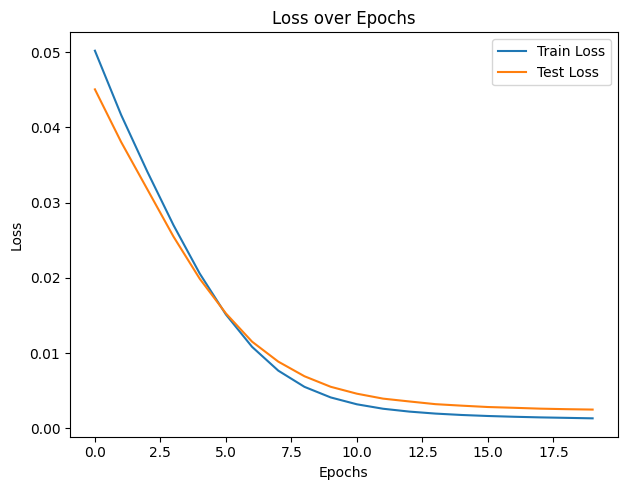

In [8]:
# 可视化结果
def show(train_loss_list, test_loss_list, train_accuracy_list=None, test_accuracy_list=None):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
     
    if train_accuracy_list != None:
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_list, label='Train Accuracy')
        plt.plot(test_accuracy_list, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
show(train_loss_list, test_loss_list)

### 二分类问题

In [9]:

# 数据集参数
size = 10000
train_size = 7000
test_size = 3000
feature_dim = 200
mean1, mean2 = 1, -1
std = 1

# 生成特征
features1 = np.random.normal(mean1, std, (size, feature_dim))
features2 = np.random.normal(mean2, std, (size, feature_dim))

# 生成标签
labels1 = np.zeros(size)
labels2 = np.ones(size)

# 划分训练集和测试集
train_features1, test_features1 = features1[:train_size], features1[train_size:]
train_labels1, test_labels1 = labels1[:train_size], labels1[train_size:]

train_features2, test_features2 = features2[:train_size], features2[train_size:]
train_labels2, test_labels2 = labels2[:train_size], labels2[train_size:]

# 拼接
train_features = np.concatenate((train_features1, train_features2), axis=0)
train_labels = np.concatenate((train_labels1, train_labels2), axis=0)
test_features = np.concatenate((test_features1, test_features2), axis=0)
test_labels = np.concatenate((test_labels1, test_labels2), axis=0)

# 转换为 PyTorch 张量
train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# 创建 TensorDataset
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

# 创建 DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 测试
for i, (X, y) in enumerate(train_loader):
    print("Dataset - Train Batch:", X.shape, y.shape)
    # print(y)
    break
for X, y in test_loader:
    print("Dataset - Test Batch:", X.shape, y.shape)
    # print(y)
    break

Dataset - Train Batch: torch.Size([256, 200]) torch.Size([256])
Dataset - Test Batch: torch.Size([256, 200]) torch.Size([256])


In [10]:
# 定义二元交叉熵损失函数
def myBCEWithLogitsLoss(pred, y):
    '''
    pred: shape: (N, 1)
    y: shape: (N, 1)
    '''
    pred = torch.sigmoid(pred)
    return torch.mean(-y * torch.log(pred + 1e-7) - (1 - y) * torch.log(1 - pred + 1e-7))

# 验证
pred = torch.randn((3, 1))  # 模拟的模型输出
y = torch.empty((3, 1)).random_(2)  # 随机生成的二分类目标

myloss = myBCEWithLogitsLoss(pred, y)
loss = nn.BCEWithLogitsLoss()(pred, y)

myloss, loss

(tensor(1.5302), tensor(1.5302))

In [11]:
# 定义超参数
lr = 0.01
num_epochs = 20

# 定义准确率
def accuracy(y_hat, y):
    y = y.reshape(-1, 1)
    return ((y_hat > 0.5).float() == y).float().mean().item()

model = myFFN(num_inputs=feature_dim, num_outputs=1, num_hiddens=64)
loss_fn = myBCEWithLogitsLoss

def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    # 记录训练时间
    start_time = time.time()
    
    # 记录训练和测试的损失和准确率
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        test_loss = 0
        test_accuracy = 0
        train_batch_num = 0
        test_batch_num = 0

        for X, y in train_loader:
            pred = model(X)
            y = y.reshape(-1, 1).float()
            loss = loss_fn(pred, y)
            loss.backward()
            mySGD(model.params, lr)
            for param in model.params:
                param.grad.zero_()
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
            train_batch_num += 1

        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                y = y.reshape(-1, 1).float()
                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
                test_batch_num += 1

        train_loss /= train_batch_num
        train_accuracy /= train_batch_num          
        test_loss /= test_batch_num
        test_accuracy /= test_batch_num
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    print(f'Training time: {time.time() - start_time:.2f}s')
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

Epoch [1/20], Train Loss: 0.6168, Train Accuracy: 0.5435, Test Loss: 0.4390, Test Accuracy: 0.9989
Epoch [2/20], Train Loss: 0.2137, Train Accuracy: 0.9999, Test Loss: 0.0787, Test Accuracy: 1.0000
Epoch [3/20], Train Loss: 0.0473, Train Accuracy: 1.0000, Test Loss: 0.0283, Test Accuracy: 1.0000
Epoch [4/20], Train Loss: 0.0210, Train Accuracy: 1.0000, Test Loss: 0.0156, Test Accuracy: 1.0000
Epoch [5/20], Train Loss: 0.0127, Train Accuracy: 1.0000, Test Loss: 0.0103, Test Accuracy: 1.0000
Epoch [6/20], Train Loss: 0.0089, Train Accuracy: 1.0000, Test Loss: 0.0076, Test Accuracy: 1.0000
Epoch [7/20], Train Loss: 0.0067, Train Accuracy: 1.0000, Test Loss: 0.0059, Test Accuracy: 1.0000
Epoch [8/20], Train Loss: 0.0053, Train Accuracy: 1.0000, Test Loss: 0.0048, Test Accuracy: 1.0000
Epoch [9/20], Train Loss: 0.0044, Train Accuracy: 1.0000, Test Loss: 0.0040, Test Accuracy: 1.0000
Epoch [10/20], Train Loss: 0.0037, Train Accuracy: 1.0000, Test Loss: 0.0034, Test Accuracy: 1.0000
Epoch [11

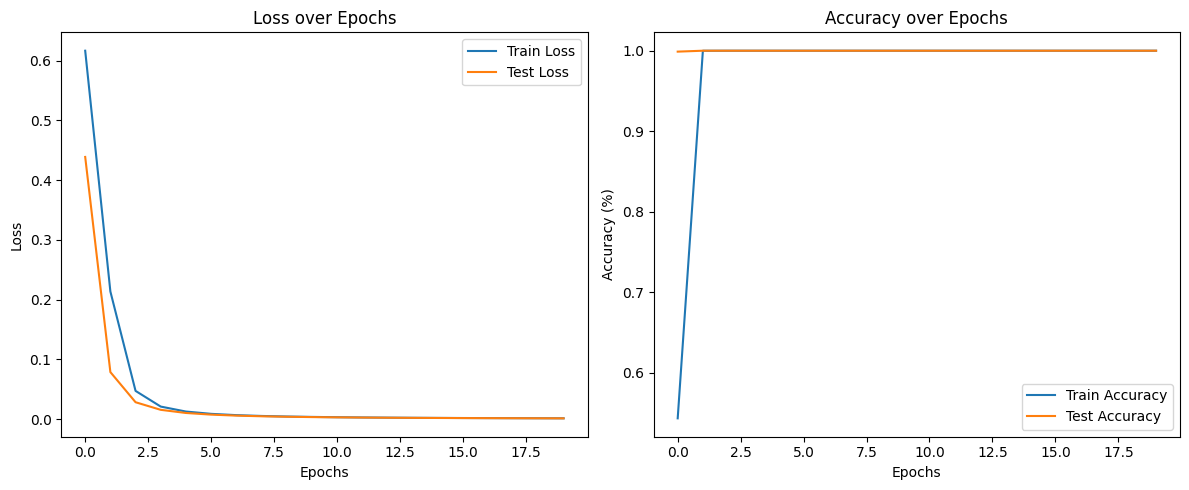

In [12]:
show(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list)

### 多分类问题

In [18]:
# 下载MINIST手写数字数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [19]:
# 定义交叉熵损失函数
def myCrossEntropyLoss(y_hat, y):
    """
    y_hat: shape: (N, C)
    y: shape: (N,)
    """
    def log_softmax(x):
        max_v = torch.max(x, dim=1, keepdim=True)[0]
        return x - max_v - torch.log(torch.sum(torch.exp(x - max_v), dim=1, keepdim=True))
    return -torch.mean(torch.gather(log_softmax(y_hat), 1, y.view(-1, 1)))

# 验证
y_hat = torch.randn((3, 10))  # 模拟的模型输出
y = torch.empty(3, dtype=torch.long).random_(10)  # 随机生成的标签

myloss = myCrossEntropyLoss(y_hat, y)
loss = nn.CrossEntropyLoss()(y_hat, y)
myloss, loss

(tensor(2.7362), tensor(2.7362))

In [21]:
# 定义超参数
lr = 0.03
num_epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)


model = myFFN(num_inputs=28*28, num_outputs=10, num_hiddens=256, device=device)
loss_fn = myCrossEntropyLoss


# 定义准确率
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == y).float().mean().item()

def train(model, train_loader, test_loader, loss_fn, num_epochs, lr):
    
    # 记录训练和测试的损失和准确率
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_accuracy = 0
        test_loss = 0
        test_accuracy = 0
        train_batch_num = 0
        test_batch_num = 0

        for X, y in train_loader:
            X = X.view(-1, 28*28).to(device)
            y = y.to(device)
            pred = model(X)
            
            loss = loss_fn(pred, y)
            loss.backward()
            mySGD(model.params, lr)
            for param in model.params:
                param.grad.zero_()
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
            train_batch_num += 1

        with torch.no_grad():
            for X, y in test_loader:
                X = X.view(-1, 28*28).to(device)
                y = y.to(device)
                pred = model(X)

                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
                test_batch_num += 1

        train_loss /= train_batch_num
        train_accuracy /= train_batch_num          
        test_loss /= test_batch_num
        test_accuracy /= test_batch_num
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    print(f'Training time: {time.time() - start_time:.2f}s')
    
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list = train(model, train_loader, test_loader, loss_fn, num_epochs, lr)

Using device: cuda
Epoch [1/20], Train Loss: 1.9294, Train Accuracy: 0.5910, Test Loss: 1.1775, Test Accuracy: 0.7591
Epoch [2/20], Train Loss: 0.8104, Train Accuracy: 0.8127, Test Loss: 0.5748, Test Accuracy: 0.8552
Epoch [3/20], Train Loss: 0.5195, Train Accuracy: 0.8668, Test Loss: 0.4388, Test Accuracy: 0.8854
Epoch [4/20], Train Loss: 0.4291, Train Accuracy: 0.8840, Test Loss: 0.3815, Test Accuracy: 0.8961
Epoch [5/20], Train Loss: 0.3852, Train Accuracy: 0.8938, Test Loss: 0.3495, Test Accuracy: 0.9025
Epoch [6/20], Train Loss: 0.3583, Train Accuracy: 0.8993, Test Loss: 0.3292, Test Accuracy: 0.9070
Epoch [7/20], Train Loss: 0.3400, Train Accuracy: 0.9037, Test Loss: 0.3146, Test Accuracy: 0.9090
Epoch [8/20], Train Loss: 0.3255, Train Accuracy: 0.9076, Test Loss: 0.3031, Test Accuracy: 0.9117
Epoch [9/20], Train Loss: 0.3141, Train Accuracy: 0.9108, Test Loss: 0.2923, Test Accuracy: 0.9158
Epoch [10/20], Train Loss: 0.3038, Train Accuracy: 0.9137, Test Loss: 0.2854, Test Accurac

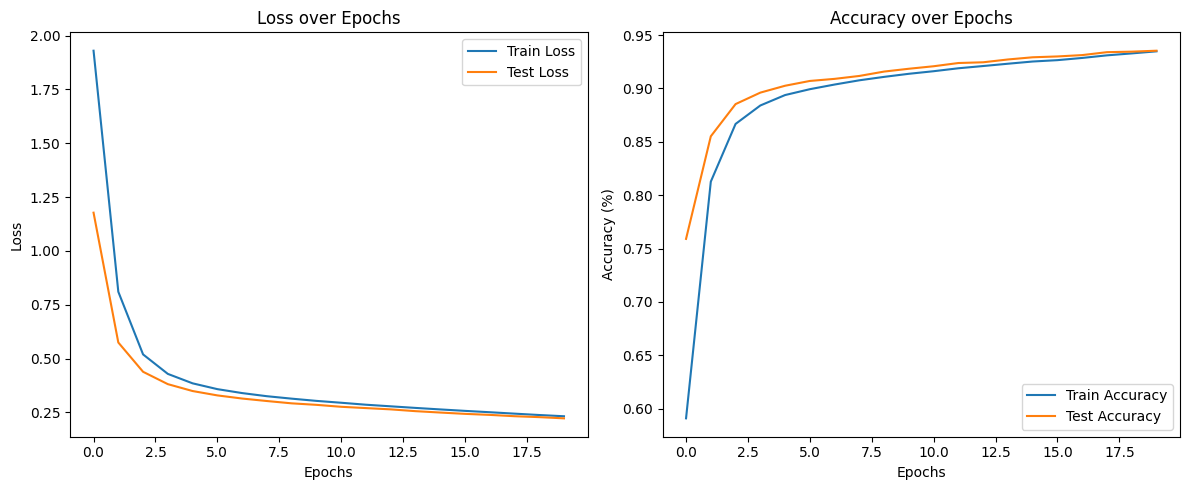

In [22]:
show(train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list)